# TD3

**Author:** [pavelkolev](https://github.com/PavelKolev)<br>
**Extending the work of:** [amifunny](https://github.com/amifunny)<br>
**Date created:** 2020/09/22<br>
**Last modified:** 2020/09/22<br>
**Description:** Implementing TD3 algorithm on the LunarLanderContinuous-v2.

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

!pip install box2d-py

Selecting previously unselected package xvfb.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.6_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.6) ...
Setting up xvfb (2:1.19.6-1ubuntu4.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.
     |████████████████████████████████| 450kB 5.5MB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import gym
import numpy as np

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [3]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

dim_state = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(dim_state))

dim_action = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(dim_action))

lower_bound = env.action_space.low[0]
upper_bound = env.action_space.high[0]

print("Min Value of Action ->  {}".format(lower_bound))
print("Max Value of Action ->  {}".format(upper_bound))

Size of State Space ->  8
Size of Action Space ->  2
Min Value of Action ->  -1.0
Max Value of Action ->  1.0


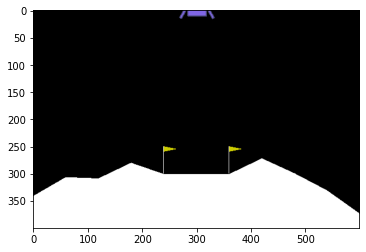

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(env.render('rgb_array'))
plt.show()

To implement better exploration by the Actor network, we use noisy perturbations, specifically
an **Ornstein-Uhlenbeck process** for generating noise, as described in the paper.
It samples noise from a correlated normal distribution.

In [5]:
class Gaussian:
    def __init__(self, mean, std_deviation, bounds = None):
        self.mean = mean
        self.std_dev = std_deviation
        self.bounds = bounds
        
    def __call__(self):
        x = np.random.normal(self.mean, self.std_dev, self.mean.shape)
        if not self.bounds == None:
            x = np.clip(x, self.bounds[0], self.bounds[1])
        return x

---
TD3 Algorithm Explained:

https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#td3

![Algorithm](https://lilianweng.github.io/lil-log/assets/images/TD3.png)
---

-----------------------------

Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation. `BatchNormalization` is used to normalize dimensions across
samples in a mini-batch, as activations can vary a lot due to fluctuating values of input
state and action.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [6]:
# mu(s) = a
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    inputs = layers.Input(shape=(dim_state,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(128, activation="relu")(out)
    outputs = layers.Dense(dim_action, activation="tanh")(out)

    # Scaling: Upper bound
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


# Q(s,a)
def get_critic():
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(32, activation="relu")(state_input)
    
    # Action as input
    action_input = layers.Input(shape=(dim_action))
    action_out = layers.Dense(32, activation="relu")(action_input)
    
    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])
    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(128, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

## Training hyperparameters

In [7]:
# Learning rate for actor-critic models
critic_lr = 0.001
actor_lr  = 0.0001

total_episodes = 4000

# Size N
N      = 2 ** 16
size_B = 2 ** 6

# Discount factor for future rewards
gamma = 0.99

# Used to update target networks
tau = 0.005


In [8]:
noise_mu = Gaussian(mean = np.zeros(dim_action),
                    std_deviation = float( 0.1 ) * np.ones(dim_action))

noise_Q  = Gaussian(mean = np.zeros(dim_action),
                    std_deviation = float(0.2) * np.ones(dim_action),
                    bounds = [-0.5, 0.5])

# Function Approx: mu and Q(s,a)
mu   = get_actor()
mu_t = get_actor()

Q1   = get_critic()
Q1_t = get_critic()

Q2   = get_critic()
Q2_t = get_critic()

# Making the weights equal initially
mu_t.set_weights(mu.get_weights())
Q1_t.set_weights(Q1.get_weights())
Q2_t.set_weights(Q2.get_weights())

mu_opt = tf.keras.optimizers.Adam(actor_lr)
Q1_opt = tf.keras.optimizers.Adam(critic_lr)
Q2_opt = tf.keras.optimizers.Adam(critic_lr)

`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [9]:
def policy(actor, state, noise_object):
    # Call "actor" mu
    sampled_actions = tf.squeeze( actor(state) )

    # Sample Noise
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    
    # Legal action
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    
    return legal_action


@tf.function
def policy_symbolic(actor, state, noise_object):
    sampled_actions = tf.squeeze( actor(state) )

    # Sample Noise
    noise = noise_object()
    sampled_actions = sampled_actions + noise
    
    # Legal action
    legal_action = tf.clip_by_value(sampled_actions, lower_bound, upper_bound)
    
    return legal_action


In [10]:
# Eager execution is turned on by default in TensorFlow 2.
# Decorating with tf.function allows TensorFlow to build a static graph 
# out of the logic and computations in our function.
# This provides a large speed up for blocks of code that contain
# many small TensorFlow operations such as this one.

# Input: each has dim [batch,?]
@tf.function
def update_Q1_Q2(state, action, reward, next_state, is_done):
    
    with tf.GradientTape(persistent = True) as tape:
        next_action = tf.stop_gradient( policy_symbolic(mu_t, next_state, noise_Q) )
        
        Q1_t_nsa    = tf.stop_gradient( Q1_t([next_state, next_action]) )
        Q2_t_nsa    = tf.stop_gradient( Q2_t([next_state, next_action]) )

        y = reward + (1.0 - is_done) * gamma * tf.math.minimum(Q1_t_nsa, Q2_t_nsa)

        Q1_nsa = Q1([state, action])
        Q2_nsa = Q2([state, action])

        diff_1_squared = tf.math.square(y - Q1_nsa)
        diff_2_squared = tf.math.square(y - Q2_nsa)

        Q1_loss = tf.math.reduce_mean(diff_1_squared)
        Q2_loss = tf.math.reduce_mean(diff_2_squared)

    Q1_vars = Q1.trainable_variables
    Q1_grad = tape.gradient(Q1_loss, Q1_vars)
    Q1_opt.apply_gradients(zip(Q1_grad, Q1_vars))

    Q2_vars = Q2.trainable_variables
    Q2_grad = tape.gradient(Q2_loss, Q2_vars)
    Q2_opt.apply_gradients(zip(Q2_grad, Q2_vars))
    

# Input: each has dim [batch,?]
@tf.function
def update_mu(state, action):

    with tf.GradientTape() as tape:
        actions = mu(state)
        Q1_sa = Q1([state, actions])
        # Used "-value" as we want to maximize the value given
        # by the critic for our actions
        mu_loss = -tf.math.reduce_mean(Q1_sa)

    mu_vars = mu.trainable_variables
    mu_grad = tape.gradient(mu_loss, mu_vars)
    mu_opt.apply_gradients(zip(mu_grad, mu_vars))


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (t, w) in zip(target_weights, weights):
        t.assign( (1 - tau) * t + tau * w )



In [11]:
class Buffer:
    def __init__(self, capacity=2**14, batch_size=2**3):
        self.batch_size = batch_size
        self.capacity   = capacity
        self.buffer_index = 0
        
        # capacity
        self.state      = np.zeros((capacity, dim_state))
        self.action     = np.zeros((capacity, dim_action))
        self.reward     = np.zeros((capacity, 1))
        self.next_state = np.zeros((capacity, dim_state))
        self.is_done    = np.zeros((capacity, 1))


    # Takes (s,a,r,s',done) obervation tuple 
    def record(self, obs_tuple):
        # Set index to zero if capacity is exceeded,
        # replacing old records
        index = self.buffer_index % self.capacity

        self.state[index]      = obs_tuple[0]
        self.action[index]     = obs_tuple[1]
        self.reward[index]     = obs_tuple[2]
        self.next_state[index] = obs_tuple[3]
        self.is_done[index]    = obs_tuple[4]

        self.buffer_index += 1
        
    
    # We compute the loss and update parameters
    def learn(self, update_mu_target):
        # Get sampling range
        record_range = min(self.buffer_index, self.capacity)

        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)
        
        # Convert to tensors
        state_batch      = tf.convert_to_tensor(self.state[batch_indices])
        action_batch     = tf.convert_to_tensor(self.action[batch_indices])
        reward_batch     = tf.convert_to_tensor(self.reward[batch_indices])
        reward_batch     = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state[batch_indices])
        is_done_batch    = tf.convert_to_tensor(self.is_done[batch_indices])
        is_done_batch    = tf.cast(is_done_batch, dtype=tf.float32)
        
        # Update Current Models
        deltas = update_Q1_Q2(state_batch, action_batch, reward_batch,
                              next_state_batch, is_done_batch)

        # Train Target Models
        if update_mu_target:
            
            # Update policy mu
            update_mu(state_batch, action_batch)
            
            # Update All Target models
            update_target(Q1_t.variables, Q1.variables, tau)
            update_target(Q2_t.variables, Q2.variables, tau)
            update_target(mu_t.variables, mu.variables, tau)


Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

In [12]:
from IPython.display import clear_output
from tqdm import trange

# To store reward history of each episode
ep_reward_list = []

# To store average reward history of last few episodes
avg_reward_list = []

# Create Buffer
buffer = Buffer(N, size_B)


In [13]:
def save_weights():
    # Save the weights
    mu.save_weights("mu.h5")
    mu_t.save_weights("mu_t.h5")

    Q1.save_weights("Q1.h5")
    Q1_t.save_weights("Q1_t.h5")

    Q2.save_weights("Q2.h5")
    Q2_t.save_weights("Q2_t.h5")
    

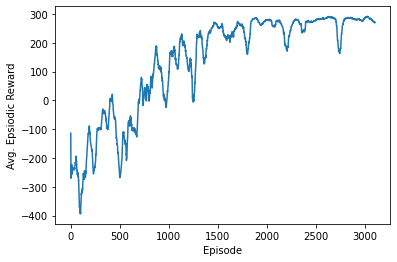

 78%|███████▊  | 3104/4001 [1:43:52<16:29,  1.10s/it]

KeyboardInterrupt: ignored

In [14]:
total_episodes = 4000

# Takes about 4 min to train
is_train_done = False
curr_iter     = 0

for ep in trange(total_episodes + 1):

    prev_state = env.reset()
    episodic_reward = 0
    
    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        action = policy(mu, tf_prev_state, noise_mu)
        
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)
        reward = reward / 200.
                
        obs_tuple = (prev_state, action, reward, state, done)
        buffer.record(obs_tuple)

        episodic_reward += reward

        update_mu_target = (curr_iter % 2 == 0 )
        buffer.learn(update_mu_target)
        
        # End this episode when `done` is True
        if done:
            break

        prev_state = state
        curr_iter += 1

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(200 * avg_reward)


    if ep % 50 == 0:
        # Plotting graph
        # Episodes versus Avg. Rewards

        clear_output(True)
        plt.plot(avg_reward_list)
        plt.xlabel("Episode")
        plt.ylabel("Avg. Epsiodic Reward")
        plt.show()

        if avg_reward >= 200:
            print("Pass!")
            is_train_done = True
            break
    
    if is_train_done:
        save_weights()
        break

    if ep >=1 and ep % 500 == 0:
        save_weights()


Evaluate Learned Agent

In [15]:
def det_policy(state):
    # Use deterministic actor: "mu"
    sampled_actions = tf.squeeze( mu(state) )
    
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return legal_action

In [16]:
def evaluate(env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        obs = env.reset()
        total_reward = 0

        while True:
            action = det_policy(obs[None])
            obs, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
        
    return game_rewards

In [17]:
import gym.wrappers

with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(env_monitor, n_games=10)

print("Final mean reward", np.mean(final_rewards))

Final mean reward 274.87823239927627


---------

--------------------

--------------------

In [18]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Sep 26 21:53:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |    295MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.
